**Modélisation du slicing dans les réseaux 5G**
-

**Bárbara Barsi Duarte Batista da Silva**

**Rafaela de Carvalho Machado Pinheiro**


--- 

*This is the English version of the project. For the French version, please refer to the `Slicing_Duarte_Pinheiro_FR.ipynb` file.*  
&nbsp;  
We originally made the whole project in English as we felt we were able to better answer the questions and explain our thoughts. We then used a translator to translate the answers into French. Excuse us for any mistakes in the French file, and please refer to this version if some of reasoning in French is unclear. Thank you for your understanding.

---

**_Library import_**

In [259]:
import math
import numpy as np
import matplotlib.pyplot as plt

---

## Introduction
La 5G permet de déployer des réseaux virtuels de bout en bout, avec des profils de qualité de service (QoS) spécifiques, au-dessus d’une infrastructure physique commune. Le slicing est le terme utilisé pour désigner la fonctionnalité qui rend cette coexistence possible. Chaque réseau virtuel déployé est appelé une tranche dans la terminologie de la 5G. Le découpage en tranches est particulièrement difficile à dimensionner pour respecter les contraintes de qualité de service des tranches. Par exemple, des tranches telles que le haut débit mobile amélioré (eMBB) et les communications ultra fiables à faible latence (URLLC) ont des exigences contradictoires en matière de qualité de service.  
On s’intéresse ici à deux types distincts : les flux URLLC et eMMB. Les premiers sont des flux qui doivent être ultra-fiables et avec une faible latence. Traduit en langage de files d’attente, cela signifie que la perte doit être infime et qu’on ne peut pas se permettre de les retarder par une mise en buffer.  
Pour les flux, eMMB, comme d’habitude, ils passent quand ils peuvent même si nor malement, ils ne devraient pas souffrir de trop de délai.  
Toute la difficulté est de rtouver un moyen physique qui permette de réaliser cette priorisation tout en étant capable d’en étudier les performances pour dimensionner les ressources.  
Dans un premier temps, nous regardons un modèle théorique qui s’étudie relativement bien. Dans un deuxième temps, nous envisagerons un modèle plus réaliste à mettre en oeuvre mais qui s’étudie plus difficilement.

--- 

## 2. Préliminaires

On rappelle que la formule d’Erlang-B donne la probabilité que $ S $ serveurs soient occupés à l’état stationnaire :

$$
ErlB[\rho, S] = \frac{\rho^S}{S! \sum_{j=0}^{S} \frac{\rho^j}{j!}}
$$

On a la relation de récurrence :

$$
\frac{1}{ErlB[\rho, 0]} = 1
$$

$$
\frac{1}{ErlB[\rho, S]} = 1 + \frac{S}{\rho\cdot ErlB[\rho, S-1]}
$$

### Partie 1
1. **Écrire une fonction Python qui renvoie le nombre moyen de clients dans une file M/M/S/S à l’état stationnaire sans calculer de factorielle.**

>  &nbsp;
> 
> To perform this calculation, we can perform the calculation of $\mathbb{E[N]}$, with N being the average number of customers. As we want to know the value for the stationary state, we can say that $\mathbb{E[N]}$ is equal to the sum of the product of the probability of the system being in a state $i$, $\pi(i)$, by the state $i$ (which is equivalent to having a number $i$ of customers in the system, since there is no queue and all the customers present at the moment of analysis are being served by some server).
>
> Thus, we have that
>
> $$ \mathbb{E}[N] = \sum_{i \in \mathbb{S}} n \cdot \pi(N = i) $$
>
> We can state that the values of $\pi$ follow the normalization condition, that is, $\sum_{i \in \mathbb{S}} \pi(N = i) = 1$.
>
> As we are in the stationary state, we know that the probability variations are invariant and the chance of being in any state at this moment of the system is equal. This means that the rates of entry and exit of the states balance each other, that is:
>
> $$ \lambda_i \cdot  \pi(i-1) = \mu_i \cdot \pi(i) $$
>
> Being $\lambda_i$ the entry rate into state $i$ and $\mu_i$ the exit rate from the same. As it is an M/M/S/S system, it is possible to state that the entry rates are always constant, $\lambda$, while the exit rates from a state $i$ to $i-1$ are equal to the product of the coefficient of the service rate, $\mu$, by the number of servers occupied before the exit, $i$ (the justification for this statement can be found on page 18 of the course poly).
>
> If we were building the method so that it calculated these probabilities using factorial, we could simply use the equation $\pi(i) = \frac{\lambda^i}{i! \mu^i} \pi(0)$. However, we can use recursion to perform this calculation, since we have:
>
> $$ \pi(i) = \frac{ \lambda }{ \mu \cdot i} \cdot  \pi(i-1) $$
>
> $$ \pi(i) = \frac{ \rho }{i} \cdot  \pi(i-1) $$
>
> To determine the base case, $\pi(0)$, we just need to remember that the probabilities must sum to 1 so that the normalization condition is met. Using the version with factorial inside the summation, we have:
> $$
> \sum_{i \in \mathbb{S}} \pi(i) = \sum_{i \in \mathbb{S}}\ \frac{\lambda^i}{i! \mu^i} \pi(0) = 1
> $$
>
> $$
> \pi(0) \sum_{i \in \mathbb{S}} \frac{(\lambda/\mu)^i}{i!} = 1
> $$
>
> We can notice that inside the summation we have a Taylor series of $\mathbb{e}^{\lambda/\mu}$, so that $ \sum_{i \in \mathbb{S}} \frac{(\lambda/\mu)^i}{i!} = e^{\lambda/\mu}$. Therefore:
> $$
> \pi(0) \cdot e^{\lambda/\mu} = 1
> $$
>
> Thus, we have that the base case is $\pi(0) = e^{-\lambda/\mu}$.
>
> With this, we can calculate all probabilities recursively and apply them in the summation to obtain the final average number.
>
>  &nbsp;

In [260]:
def prob_state(p, nb_of_servers):

    if (nb_of_servers == 0):  return math.exp(-p)

    return (p/nb_of_servers) * prob_state(p, nb_of_servers - 1) 

def mean_number_waiting_customers(arrival_rate, service_rate, nb_of_servers):

    p = arrival_rate / service_rate
    mean = 0

    for i in range(0, nb_of_servers + 1):
        mean += prob_state(p, i) * i

    return mean

2. **Pour un choix de paramètre $\rho$ et $S$ tels que $ErlB[\rho, S]$ soit petit (de l’ordre de $10^{-3}$), qu’est-ce que l’on remarque à propos du nombre moyen de clients ?**  
Expliquer ce phénomène en vous aidant des résultats connus sur la M/M/$\infty$.

>  &nbsp;
> 
> Below we present the recursive method of calculation of Erlang-B, that will allow us to verify the parameters  used in the calculation of the average number of customers.
> 
>  &nbsp;

In [261]:
def erlang_b(p, nb_of_servers):

    if (nb_of_servers == 0): return 1 

    return 1/(1 + (nb_of_servers / (p * erlang_b(p, nb_of_servers - 1))))

In [262]:
S = 3
lamb = 4
mu = 20
p = lamb / mu

print(f"Charge = {p}, {S = }")
print(f"Erlang-B = {erlang_b(p, S):.4f}")
print(f"Nombre moyen de clients: {mean_number_waiting_customers(lamb, mu, S):.4f}")

Charge = 0.2, S = 3
Erlang-B = 0.0011
Nombre moyen de clients: 0.1998


> &nbsp;
> 
> Considering that $ErlB[\rho, S]$ has a considerably low value, we can assume that the system has an average of $\rho$ customers in its stationary state. We can state this based on the similarity between the behavior of this system and what we observe in the case of an M/M/$\infty$ modeling.
> 
> With a low Erlang-B value, we know that the system can serve customers with a significantly low probability of all $S$ servers being unavailable, while in the case of infinite servers, the probability of service blocking is null, precisely because of the infinite number of servers available to serve the customers.
> 
> Since there is a low chance of having no free servers for service, the average number of customers in the system becomes driven by the arrival and service rates (that is, $\lambda/\mu = \rho$), rather than by the potential blocking of an exhausted system.
> 
> &nbsp;

--- 

## 3. Modélisation

On suit le modèle proposé dans [1] qui n’est pas implémentable dans un système réel mais qui s’analyse mathématiquement très bien.

On considère une file d’attente avec un buffer infini et $ S $ serveurs. Il y a deux classes de clients de type 1 et de type 2. Les clients de type 1 ont une priorité plus élevée que les clients de type 2. Les clients de type 1 arrivent selon un processus de Poisson de paramètre $ \lambda_1 $ et les clients de type 2 arrivent selon un processus de Poisson de paramètre $ \lambda_2 $. Les clients de type 1 ont une durée de service exponentielle de paramètre $ \mu_1 $ et les clients de type 2 ont une durée de service exponentielle de paramètre $ \mu_2 $.

Les clients de type 1 ne peuvent pas être bufferisés et doivent être servis immédiatement. Les clients de type 2 peuvent être bufferisés. On suppose que la capacité de la file d’attente est infinie.

Les clients de classe 1 préemptent les serveurs : s’il reste des serveurs libres, ils s’y mettent normalement mais si tous les serveurs sont pris, ils prennent la place d’un client de classe 2. Celui-ci se retrouve dans le buffer et reprendra son service, là où il en était, dès qu’un serveur se libérera. S’il n’y a que des clients de classe 1 en service, le client de type 1 qui arrive est perdu.

Les clients de classe 2 ne peuvent accéder à un serveur que s’il y en a de libre. S’ils arrivent et qu’il n’y a pas de serveur libre, ils sont mis dans le buffer.

On note $ Q_1 $ le nombre de clients de type 1 dans le système et $ Q_2 $ le nombre de clients de type 2 dans le système. On note $ S_1 $ le nombre de serveurs occupés par des clients de type 1 et $ S_2 $ le nombre de serveurs occupés par des clients de type 2. On note $ B $ le nombre de clients de type 2 dans le buffer.


### Partie 2

1. **Quelles sont les contraintes sur les variables d’état du système et comment les variables $ Q_2 $, $ S_2 $ et $ B $ sont-elles reliées ?**  
   Expliquer en particulier pourquoi $ Q_1 + S_2 < S $ ne peut se produire que si $ B = 0 $.

> &nbsp;
> 
> $Q_2$ is the number of clients of class 2; $S_2$ is the number of servers currently occupied by class 2 clients; $B$ is the occupied buffer, which can only be occupied by class 2 clients, thus it is the number of class 2 clients waiting to be served.  
> From these definitions, we get the following relations:  
> - $S_1 = Q_1$: Type 1 clients do not stay in the buffer, thus every type 1 client in the system is being served.
> - **$S_2 \leq Q_2$**: Since $Q_2 $ is the total number of clients in system, it includes clients in the buffer and clients being served $S_2$. Thus, the number of class 2 clients being served $S_2$ can never exceed the total amount of class 2 clients in the system $Q_2$
> - **$B \leq Q_2$**: Similarly, the number of class 2 clients waiting in the buffer can never be larger than the total amount of class 2 clients in the whole system, because they are the only ones sent to the buffer - as class 1 clients do not wait.
> - **$Q_2 = S_2 + B$**: Only class 2 clients stay in the buffer, so they can eiter be in the buffer or being served.  
> 
> With that, $Q_1 + S_2 < S$ implies $B=0$: The buffer will only be empty ($B=0$) if all class 2 clients are being served. Since class 1 clients cannot wait and are served immediately, we have $Q_1 = S_1$, thus we can rewrite the statement as $S_1 + S_2 < S$. This means there are unoccupied servers, thus there would not be any clients in the buffer.
> 
> &nbsp;


2. **Montrer que le processus $ Q_1 $ est un processus de Markov et reconnaître sa dynamique comme celle d’une file simple dont on précisera les caractéristiques.**

> &nbsp;
>
> The process Q1 can be modeled as an M/M/S/S system due to certain characteristics of the functioning of the servers and the organization of the clients.
>
> As type 1 clients arrive at the system considering an exponential arrival rate with parameter $\lambda_1$ and are served with an exponential service rate with parameter $\mu_1$, we can verify that this is the Markovian behavior denoted by the letters M/M in the modeling.
> 
> The analyzed system has the peculiarity of giving priority to clients 1, that is, all servers that are not being used by this type of client are available for service, with clients 2 having their execution interrupted and consequently returning to the buffer after this replacement in the service. With this, we can state that all the S servers are available for clients 1.
> 
> However, another peculiarity of the system is that these clients cannot shelter in the buffer, that is, if all servers are occupied serving some client of this type, the client automatically leaves the system. As there is no interference from the existence of type 2 clients in this behavior, we can say that there is no queue for clients 1, which confirms the S/S nature of this type of execution.
>
> &nbsp;


3. **Écrire les transitions possibles du processus de Markov ($Q_1$, $Q_2$).**  
   Montrer en particulier que le taux de transition de l’état $ (q_1, q_2) $ à l’état $ (q_1, q_2-1) $ est donné par :
   $$\min\{q_2, S - q_1\} \mu_2$$


> &nbsp;
> 
> There are 4 possible transitions:
> - $q_1 \rightarrow q_1+1$, when a class 1 client arrives with rate $\lambda_1$
> - $q_2 \rightarrow q_2+1$, when a class 2 client arrives with rate $\lambda_2$
> - $q_1 \rightarrow q_1-1$, when a class 1 client leaves with rate $q_1\mu_1$
> - $q_2 \rightarrow q_2-1$, when a class 2 client leaves with rate $min\{q_1, S - q_1\}\mu_2$
> 
> *Obs.:* at each transition, only the specified state is changed (*i.e.*, in $q_1 \rightarrow q_1+1$, $q_2$ remains the same)
> 
> Since type 1 clients can preemt servers serving type 2 clients at any time, we have $S-Q_1$ as the amount of available servers + the amount of servers occupied by type 2 clients, then at most $S-Q_1$ $(Q_2 < S-Q_1)$. This can be rewritten as $Q_1 + Q_2 < S$, and as we proved above, $Q_1 + Q_2 < S \rightarrow B = 0$, which means there are no clients in the buffer, they are all being served ($Q_2 = S_2$). On the other hand, if $B>0$ - meaning there are no free servers - we get that $S_2=S-Q_1$. Thus, $S_2$ is at least equal to $Q_2$ but at most equal to $S-Q_1$, meaning that $S_2=min\{q_1, S - q_1\}\mu_2$  
>
> &nbsp; 

---

   
4. **Simuler l’évolution de ce système en Python.**  
   On prendra comme valeurs $ S = 10, \mu_1 = 2, \mu_2 = 1, \lambda_1 = 4, \lambda_2 = 3 $.

   On note $ (x_1, x_2) $ le processus ainsi construit. On vérifiera notamment que :

$$
\frac{1}{T} \int_0^T 1_{\{S\}}(x_1(s)) \, ds \xrightarrow{T\rightarrow \infty} \frac{\rho_1^S/S!}{\sum_{j=0}^{S} {\rho_1^j}/{j!}}
$$

> &nbsp;
> 
> The function below tracks three main variables: the number of class 1 customers in service (q1), the number of class 2 customers in service (s2), and the number of class 2 customers in the buffer (b2). It also generates random arrival times for both classes of customers and random service times.
>
> It simulates events happening at different times, then it checks if servers are available when a customer arrives, and when a server is freed. At class 1 arrivals, if servers are not available but class 2 customers are being served, one is pushed to the buffer. It also observes how much time all servers have spent busy with class 1 customers only.
>
> After running many times (T=100000 ), it calculates the proportion of that time when all servers had only class 1 customers. 
>
> The goal is to demonstrate that if all of the servers become occupied by class 1 customers, the system behaves like an ordinary "loss system" in which new arrivals of class 1 are not accepted and that this corresponds with the theoretical formula. 
> 
> &nbsp;

In [263]:
def simulation(S, mu_1, mu_2, lambda_1, lambda_2, T):
    current_time = 0
    busy_time_class1_full = 0 # track how much of the time servers are busy with class 1

    q1 = 0  # class 1 in service
    s2 = 0  # class 2 in service
    b2 = 0  # class 2 in buffer

    # scheduled events: (time, type) -> type in ["arrival1", "arrival2", "dep1_i", "dep2_i"]
    events = []

    # generate arrival times
    arrival_times1 = np.cumsum(np.random.exponential(1 / lambda_1, int(2 * lambda_1 * T)))
    arrival_times2 = np.cumsum(np.random.exponential(1 / lambda_2, int(2 * lambda_2 * T)))
    i1 = i2 = 0

    # service times for class 1 and class 2
    def gen_service1(): return np.random.exponential(1 / mu_1)
    def gen_service2(): return np.random.exponential(1 / mu_2)

    servers = []  # list of (end_time, class), class = 1 or 2

    while current_time < T:
        # schedule next arrivals if available
        next_arrival1 = arrival_times1[i1] if i1 < len(arrival_times1) else float('inf')
        next_arrival2 = arrival_times2[i2] if i2 < len(arrival_times2) else float('inf')

        # find next departure
        if servers:
            next_departure_time, _ = min(servers, key=lambda x: x[0])
        else:
            next_departure_time = float('inf')

        # choose the next event
        next_event_time = min(next_arrival1, next_arrival2, next_departure_time)
        if next_event_time > T:
            break

        # track busy time for class 1 fully occupying servers
        if q1 == S:
            busy_time_class1_full += next_event_time - current_time

        current_time = next_event_time

        if next_event_time == next_arrival1:
            i1 += 1
            if q1 < S:
                q1 += 1
                servers.append((current_time + gen_service1(), 1))
            elif s2 > 0:
                # preempt a class 2 client
                s2 -= 1
                b2 += 1
                servers = [(t, c) for t, c in servers if not (c == 2 and t == max(t for t, c in servers if c == 2))]
                q1 += 1
                servers.append((current_time + gen_service1(), 1))
            # else: lost

        elif next_event_time == next_arrival2:
            i2 += 1
            if q1 + s2 < S:
                s2 += 1
                servers.append((current_time + gen_service2(), 2))
            else:
                b2 += 1

        elif next_event_time == next_departure_time:
            # remove the client that is leaving
            for idx, (t, c) in enumerate(servers):
                if t == next_departure_time:
                    departing_class = c
                    servers.pop(idx)
                    break
            if departing_class == 1:
                q1 -= 1
            else:
                s2 -= 1
                if b2 > 0:
                    b2 -= 1
                    s2 += 1
                    servers.append((current_time + gen_service2(), 2))

    return busy_time_class1_full / T


In [264]:
S = 10              # servers
mu_1 = 2            # service rate
mu_2 = 1
lambda_1 = 4        # arrival rate
lambda_2 = 3
T = 100000           # total simulation time

sim_erlang_b = simulation(S, mu_1, mu_2, lambda_1, lambda_2, T=100000)
theoretical_erlang_b = erlang_b(lambda_1/mu_1, S)

print(f"Simulated Erlang-B: {sim_erlang_b}")
print(f"Theoretical Erlang-B: {theoretical_erlang_b}")
print(f"Difference: {np.abs(sim_erlang_b - theoretical_erlang_b)}")

Simulated Erlang-B: 2.7258071025707978e-05
Theoretical Erlang-B: 3.819016794126352e-05
Difference: 1.0932096915555543e-05


> &nbsp;
> 
> The left-hand side of the equation is the fraction of time all servers are busy with class 1 clients, and as $T\rightarrow\infty$, it converges to a stationary state probability that all servers are occupied by class 1.
> The right-hand side is the Erlang-B formula, and it should match the left-hand side as it represents the blocking probability in a $M/M/S/S$ queue - such as the $Q_1$ model above.
> According to our calculations, there is no significant difference between the theoretical (left-hand side) and the result from the simulation (right-hand side).
>
> &nbsp;

## 4. Stationnarité

Il est montré dans [1] que ce système admet un régime stationnaire si et seulement si :

$$
\rho_2 + \frac{1}{\sum_{j=0}^{S} \rho_1^j/j!} \sum_{k=0}^{S} k\frac{\rho_1^k}{k!} < S
$$

où $ \rho_i = \frac{\lambda_i}{\mu_i} $.

### Partie 3

1. **Illustrer ce résultat par simulation. Serait-il possible de deviner (2) par simulation ?**


> &nbsp;
>
> We can show this condition through simulation, but discovering it via simulation is very difficult. Even by simulating a wide range of parameters ($\lambda_1, \lambda_2, \mu_1, \mu_2, S$), we would only get a numerical approximation of the stability boundary, not the exact formula.  
> We will create a `stability` function to verify the results with many different parameters below
> 
> &nbsp;

In [265]:

def stability(S, mu_1, mu_2, lambda_1, lambda_2):
    rho_1 = lambda_1 / mu_1
    rho_2 = lambda_2 / mu_2

    sum_rho = sum(rho_1**j / math.factorial(j) for j in range(S+1))
    sum_krho = sum(k * rho_1**k / math.factorial(k) for k in range(S+1))

    result = rho_2 + (1/sum_rho) * sum_krho 
    return result < S, result

In [266]:
test_params = [
    (10, 2, 1, 4, 3),       # original params, stable
    (10, 2, 1, 4, 6),       # increase class 2 load
    (10, 2, 1, 8, 3),       # increase class 1 load
    (10, 2, 1, 15, 3),      # very high class 1 load
    (10, 2, 1, 15, 9)       # increase both loads
]

for params in test_params:
    S, mu_1, mu_2, lambda_1, lambda_2 = params
    stable, val = stability(S, mu_1, mu_2, lambda_1, lambda_2)
    print(f"Params {params}:")
    print(f"  Stability condition value: {val:.2f} (must be < {S})")
    print(f"  Predicted to be {'stable' if stable else 'unstable'}")
    
    frac = simulation(S, mu_1, mu_2, lambda_1, lambda_2, T=10000)
    print(f"  Simulated fraction of time all class 1: {frac:.4f}\n")

Params (10, 2, 1, 4, 3):
  Stability condition value: 5.00 (must be < 10)
  Predicted to be stable
  Simulated fraction of time all class 1: 0.0000

Params (10, 2, 1, 4, 6):
  Stability condition value: 8.00 (must be < 10)
  Predicted to be stable
  Simulated fraction of time all class 1: 0.0001

Params (10, 2, 1, 8, 3):
  Stability condition value: 6.98 (must be < 10)
  Predicted to be stable
  Simulated fraction of time all class 1: 0.0055

Params (10, 2, 1, 15, 3):
  Stability condition value: 9.75 (must be < 10)
  Predicted to be stable
  Simulated fraction of time all class 1: 0.0957

Params (10, 2, 1, 15, 9):
  Stability condition value: 15.75 (must be < 10)
  Predicted to be unstable
  Simulated fraction of time all class 1: 0.0924



---

## 5. Calcul de la probabilité stationnaire

En s’aidant de la section 6 de [1], on veut calculer la probabilité stationnaire $ \pi $ de notre système sous réserve que (2) soit satisfaite. Par définition, $ \pi $ est un vecteur de taille infinie indexée par les valeurs possibles de $ (q_1, q_2) $. On numérote les états $ (q_1, q_2) $ en ordre lexicographique à droite :

$ (0, 0) \prec (1, 0) \prec \dots \prec (S, 0) \prec (0, 1) \prec \dots \prec (S, 1) \prec \dots $

et on forme les vecteurs ligne à $ S + 1 $ coordonnées

$$
x_i = (\pi(0,i), \pi(1,i), \dots, \pi(S,i))
$$

On note $ M $ la matrice $ (S+1) \times (S+1) $ qui correspond au générateur d’une file M/M/S/S de paramètres $ \lambda_1 $ et $ \mu_1 $. Le générateur de $ (Q_1, Q_2) $ s’écrit sous forme tri-diagonale par blocs de la manière suivante :

$$
\begin{pmatrix}
M - \lambda_2 Id & \lambda_2 Id \\
A_1 & B_1 & \lambda_2 Id \\
& A_2 & B_2 & \lambda_2 Id \\
\vdots & \vdots & \ddots & \ddots & \ddots & \vdots & \vdots & \vdots & \vdots\\
& & & A_S & B_S & \lambda_2 Id \\
& & & & A_S & B_S & \lambda_2 Id \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \vdots\\
\end{pmatrix}
$$

où

$$
B_j = M - A_j - \lambda_2 Id
$$

et

$$
A_j = \text{diag}(a_{n,0}, \dots, a_{n,S})
$$

avec

$$
a_{n,j} = \min(S - j, n) \mu_2.
$$

On admet qu’il existe une matrice $ R_S $ à coefficients positifs (et les plus petits possibles) qui soit solution de l’équation matricielle :

$$
\lambda_2 Id + R_B S + R^2 A_S = 0.
$$

Pour trouver cette matrice $ R $, on réécrit cette équation sous la forme :

$$
R = -(Id + R^2 \tilde{A}_S) \tilde{B}_S^{-1}
$$

où 

$$
\tilde{A}_S=\frac{1}{\lambda_2}A_s \text{ et } \tilde{B}_S=\frac{1}{\lambda_2}B_s
$$

On considère ensuite la suite de matrices

$$
R_0 = 0
$$

$$
R_{n+1} = -(Id + R^2 \tilde{A}_n) \tilde{B}_S^{-1}.
$$

Assez rapidement, cette suite converge vers une matrice solution de l’équation précédente. La propriété selon laquelle cette matrice a les coefficients positifs les plus petits possibles est démontrée dans [2]. On admet également que le rayon spectral de cette matrice est strictement inférieur à 1, donc que $ I - R $ est inversible et que l’on a :

$$
\sum_{j=0}^{\infty} R_j = (Id - R)^{-1}.
$$

### Partie 4

1. **Montrer que la suite $ (x_j, j \geq S) $ définie par**

$$
x_j = x_S R^{j - S} \quad \text{pour} \quad j \geq S.
$$

**est solution des équations d’équilibre au-delà du rang $ S $.**



> &nbsp;
>
> As we are analyzing the stationary state of the system, the following equality must hold:
> 
> $$
> \pi \cdot Q = 0
> $$
> 
> where $Q$ is the transition matrix and $\pi$ is the matrix of stationary probabilities. $\pi$ can be described as:
> $$
> \pi = \begin{pmatrix} x_0 \\ x_1 \\ \vdots \end{pmatrix}
> $$
> with each $x_i$ representing the vector $\begin{pmatrix} \pi_{(0,i)} & \pi_{(1,i)} & \dots &  \pi_{(S,i)} \end{pmatrix}$.
> Thus, we have two possible balance equations:
>
> $$
> x_0 (M - \lambda_2 \cdot Id) + x_1 A_1 = 0  \text{ , for } j = 0
> $$
> $$
> x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_j + x_{j+1} A_{j+1} = 0 \text{ , for } 0 < j < S
> $$
> 
> $$
> x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_S + x_{j+1} A_S = 0 \text{ , for } j \geq S
> $$
> 
> Since we are focusing on the cases where the states are greater than or equal to $S$, we will use the second equation.
> 
> To demonstrate that the sequence $x_j = x_S \cdot R^{j-S}$ satisfies the above equation, we will consider $x_{j} = x_{S} \cdot R^{j-S}$ and show that the result of $x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_S + x_{j+1} A_S$ equals 0. Substituting into the sum, we have:
> 
> $$
> (x_S R^{j - 1 - S}) (\lambda_2 \cdot Id) + (x_S R^{j - S}) B_S + (x_S R^{j + 1 - S}) A_S
> $$
> 
> $$
> (x_S R^{j - 1 - S}) (\lambda_2 I + R B_S + R^2 A_S)
> $$
> 
> Since $ (\lambda_2 I + R B_S + R^2 A_S) = 0$,
> $$
> (x_S R^{j - 1 - S}) \cdot 0 = 0
> $$
> 
> Thus, we can state that $x_{j} = x_{S} \cdot R^{j-S}$ is a solution to the stationary equations for $j \geq S$.
>
> &nbsp;


---

2. **Établir que**

$$
x_{S-1} = -x_S (\tilde{B}_S + R \tilde{A}_S).
$$

> &nbsp;
>
> Considering the stationary state, let us once again analyze the case of $x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_S + x_{j+1} A_S$, this time observing the case where $j = S$.
> 
> $$
> x_{S - 1} \lambda_2 \cdot Id + x_S B_S + x_{S + 1} A_{S} = 0
> $$
> 
> $$
> \lambda_2 x_{S - 1} = - x_S B_S - x_S R A_{S}
> $$
> 
> $$
> x_{S - 1} = - x_S \left( \frac{B_S}{\lambda_2} + R \frac{A_{S}}{\lambda_2} \right)
> $$
> 
> Since $\frac{B_S}{\lambda_2} = \tilde{B}_S$ and $\frac{A_{S+1}}{\lambda_2} = \tilde{A}_{S}$, we can reach the initially desired equation:
> 
> $$
> x_{S - 1} = - x_S ( \tilde{B}_S + R \tilde{A}_{S})
> $$
>
> &nbsp;

--- 

3. **Expliciter par récurrence la suite de matrices $ (T_j, j = S - 1, \dots, 0) $ telle que l’on ait**

$$
x_{j+1} = x_j T_j.
$$


> &nbsp;
>
> Since $j < S$, we are going to use the second balance equation to find the recurrence.
>
> $$
> x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_j + x_{j+1} A_{j+1} = 0 
> $$
>
> Since $ x_{j+1} = x_j T_j$, we can replace it on the equation.
>
> $$
> x_{j-1} (\lambda_2 \cdot Id) + x_{j} B_j + x_{j} T_j A_{j+1} = 0 
> $$
> 
> $$
> x_{j-1} (\lambda_2 \cdot Id) + x_{j} ( B_j + T_j A_{j+1}) = 0 
> $$
>
> Dividing everything by $\lambda_2$:
>
> $$
> x_{j-1} + x_{j} ( \tilde{B}_j + T_j \tilde{A}_{j+1}) = 0 
> $$ 
>
> $$
> x_{j-1} = - x_{j} ( \tilde{B}_j + T_j \tilde{A}_{j+1}) 
> $$ 
> $$
> x_{j} = - x_{j-1} ( \tilde{B}_j + T_j \tilde{A}_{j+1})^{-1} 
> $$
>
> With that, we can state that $x_{j} = - x_{j-1} T_{j-1}$, with the followind recurrence being followed:
>
> $$ T_{j-1} = - ( \tilde{B}_j + T_j \tilde{A}_{j+1})^{-1} $$
>
> &nbsp;

---


4. **Montrer enfin que l’on a**

$$
x_0 ((M - \lambda_2 I) + T_0 A_1) = 0.
$$

où $ \tilde{M} = \frac{M}{\lambda_2} $.


> &nbsp;
>
> Observing the balance equation for $j < S$, with $j=0$, we have:
>
> $$ 
> x_0 (M - \lambda_2 I) + x_1 A_1 = 0 
> $$
>
> Since $x_{j+1} = x_{j}T_j$, $x_{1} = x_{0}T_0$:
> 
> $$ 
> x_0 (M - \lambda_2 I) + x_0 T_0 A_1 = 0
> $$
> 
> $$ 
> x_0 ((M - \lambda_2 I) + T_0 A_1) = 0 
> $$
>
> The previous equation is already the one we aimed to obtain, but if we want to express it in terms of $\tilde{M}$ and $\tilde{A}$, we just need to divide everything by $\lambda_2$.  
> 
> $$ 
> x_0 ((\tilde{M} - I) + T_0 \tilde{A}_1) = 0 
> $$
>
> &nbsp;

---


5. **Expliquer comment on calcule $ x_S $.**


> &nbsp;
>
> To find $ x_S $, we start from the balance equation at $ j = 0 $, $x_0 ( (\tilde{M} - I) + T_0 \tilde{A}_1) = 0$. This equation tells us that $x_0$ lies in the null space of:
> 
> $$
> (\tilde{M} - I) + T_0 \tilde{A}_1
> $$
> 
> Once $ x_0 $ is found (using SVD), the subsequent vectors up to $ x_S $ are computed recursively using the pre calculated matrices $T_j$ and the following relation:
> 
> $$
> x_{j+1} = x_{j} T_{j}
> \quad \text{for} \quad 0 \leq j < S
> $$
> 
> Therefore:
> 
> $$
> x_S = x_0 (T_0 \cdot T_1 \cdots T_{S-1})
> $$
> 
> In summary, we can state that $x_S $ is obtained by multiplying $ x_0 $ successively by all $ T_j $ matrices from $ j = 0 $ to $ j = S-1 $.
>
> &nbsp;


---


6. **Retrouver la Figure 2 de [1] pour $ S = 5 $.**

> &nbsp;
>
> To allow the reconstruction of the figure we aregoing to use the `MMSSQueueAnalyzer` class defined below. It models and analyzes M/M/S/S queueing systems with two types of customers, building the transition matrices, computing the necessary auxiliary matrices and finally finding the stationary distribution of the system.
> 
> The expected waiting time for type-2 customers is calculated through the method `calculate_EWQ`. It aggregates three key contributions: 
> 
> - the number of type-2 customers already present in the system,
> - the expected time spent being served, obtained via matrix inversion of the rate matrix $R$,
> - the expected number of customers waiting ahead in the queue. 
> 
> These components together represent the complete behavior of the system under stationary conditions and are normalized by the type-2 customer arrival rate $\lambda_2$ to yield the final expected waiting time.
>
> The computation of this expected time uses the equation of the article, which states:
>
> $$
> \text{EQ}_2 = \sum_{j=1}^{S-1} x_j e + S\, x_S (I - R)^{-1} e + x_S (I - R)^{-2} e
> $$
>
> &nbsp;


In [267]:
class MMSSQueueAnalyzer:
    
    def __init__(self, mu_1, lambda_1, mu_2, lambda_2, servers):

        self.mu_1 = mu_1
        self.lambda_1 = lambda_1
        self.mu_2 = mu_2
        self.lambda_2 = lambda_2
        self.S = servers 
        self.dim = servers + 1  # Dimension of the system (0 to S)
        
        # Initialize matrices to store intermediate results
        self.transition_matrix = None   # The infinitesimal generator matrix M
        self.a_matrices =  np.zeros((S + 1, S + 1, S + 1))          # Service rate matrices A_j
        self.b_matrices =  np.zeros_like(self.a_matrices)           # Combined rate matrices B_j
        self.R = np.zeros((self.dim, self.dim))                   # Matrix R
        self.t_matrices = np.zeros_like(self.a_matrices)          # Matrices T_j
        self.t_inv_matrices = np.zeros_like(self.a_matrices)           # Inverse matrices T_j
        self.stationary_dist = np.zeros((self.dim, self.dim))     # Final stationary distribution pi


    def setup(self): 
        self.build_transition_matrix()
        self.build_auxiliary_matrices()
        self.compute_R()
        self.compute_t_matrices()

    def solve_svd( self, matrix):

        return np.linalg.svd(matrix)
    
    def build_transition_matrix(self):
        """
        Constructs the transition rate matrix M for the M/M/S/S system.
        """
        # Upper diagonal: arrival transitions
        upper = np.diag([self.lambda_1] * self.S, k=1)
        
        # Main diagonal: total outflow rates
        main_diag = - np.concatenate([
                        self.lambda_1 + self.mu_1 * np.arange(self.S),  # States 0 to S-1
                        [self.S * self.mu_1]  # State S (all servers busy)
                      ])
        
        # Subdiagonal: service completion transitions
        lower = np.diag(self.mu_1 * np.arange(1, self.S + 1), k=-1)
        
        self.transition_matrix = upper + np.diag(main_diag) + lower
    
    def build_auxiliary_matrices(self):
        """
        Constructs the auxiliary matrices A and B needed for the solution.
        """
        for j in range(self.dim):
            # A[j] = diag(min(S -j, n) * µ₂)
            self.a_matrices[j] = np.diag(np.array([min(j, self.S - i) * self.mu_2 for i in range(self.dim)]))
            
            # B[j] = M - (min(S -j, n) + λ₂) * I
            self.b_matrices[j] = (self.transition_matrix - 
                                  np.diag(np.array([min(j, self.S - i) * self.mu_2 for i in range(self.dim)]) + self.lambda_2))
    
    def compute_t_matrices(self):
        """
        Computes the T matrices used in the solution.
        """
        A_ = self.a_matrices / self.lambda_2
        B_ = self.b_matrices / self.lambda_2
        
        self.t_matrices[self.S] = - B_[self.S] - self.R @ A_[self.S]
        
        for i in range(self.S - 1, -1, -1):
            self.t_inv_matrices[i+1] = np.linalg.inv(self.t_matrices[i+1])
            self.t_matrices[i] = - B_[i] - self.t_inv_matrices[i+1] @ A_[i+1]
    
    def compute_R(self, max_iterations=50):
        """
        Computes the rate matrix R using iterative numerical methods.
        
        Args: 
        max_iterations: Maximum number of iterations for convergence.  By default, 50.
        """
            
        # Normalize matrices by λ₂ for numerical stability
        A_ = self.a_matrices[self.S] / self.lambda_2
        B_ = self.b_matrices[self.S] / self.lambda_2
        
        R = np.zeros((self.dim, self.dim))
        
        # Iteratively solve for R
        for i in range(max_iterations):

            R = - (np.eye(self.dim) + self.R @ self.R @ A_) @ np.linalg.inv(B_)
            if np.isnan(self.R).any() or np.isinf(self.R).any():
                raise ValueError(f"R exploded at iteration {i}")
            
            if np.linalg.norm(self.R - R, ord='fro') < 1e-8:
                break

            self.R = R   
    
    def solve_stationary_distribution(self, tol=1e-12):
        """
        Solves for the stationary distribution π of the system.
        
        Args: 
        tol: Tolerance for null space calculation
        """
            
        # Normalize matrix M by λ₂ 
        M_ = self.transition_matrix / self.lambda_2
        
        # Solve boundary equations
        aux = M_ - np.eye(self.dim) + self.t_matrices[0] @ (self.a_matrices[1]/self.lambda_2)

        # Get singular vector corresponding to smallest singular value
        x0 = np.linalg.svd(aux)[2]
        self.stationary_dist[:, 0] = x0[-1]/np.sum(x0[-1])
        
        # Compute all remaining columns of the stationary distribution matrix
        for i in range(1, self.dim):
            self.stationary_dist[:, i] = self.stationary_dist[:, i-1] @ self.t_inv_matrices[i]

        self.stationary_dist /= np.sum(self.stationary_dist, axis=0)

    def calculate_EWQ(self):
        """
        Computes expexted waiting time for customers type 2 following the theoretical formula:
        
        EW_Q = sum_{j=1}^{S-1} x_j * e + S * x_S * (I - R)^{-1} * e + x_S * (I - R)^{-2} * e
        """

        # changing variables names to match the formula 
        e = np.ones(self.dim)
        x = self.stationary_dist  

        Id_minus_R_inv = np.linalg.inv(np.eye(self.dim) - self.R)

        #  term 1: Sum over phases j = 1 to S-1 ---
        term1 = 0
        for j in range(1, self.S):  
            term1 += x[:, j] @ e    

        # term 2: Contribution from phase S 
        term2 = self.S * (x[:, self.S] @ (Id_minus_R_inv @ e))

        # term 3: System behavior when fully occupied (higher order
        term3 = x[:, self.S] @ (Id_minus_R_inv @ Id_minus_R_inv @ e)

        # Final expected value EQ2
        EQ2 = (term1 + term2 + term3)

        # Normalize by arrival rate λ2
        return EQ2 / self.lambda_2


> &nbsp;
>
> Now, we are going to test with the same parameters provided at the article and plot the result.
>
> &nbsp;

In [268]:
# System parameters
S = 5
mu_1 = 4
mu_2 = 20
lambda_2 = 8 

# Range of lambda_1 values to test
lambdas_1 = np.linspace(0, 60, 30)
avg_times = []

for l1 in lambdas_1:
    # Create analyzer instance
    analyzer = MMSSQueueAnalyzer(mu_1, l1, mu_2, lambda_2, S)
    
    # Setup the system (transition matrix, auxiliary matrices, etc.)
    analyzer.setup()

    # Solve for stationary distribution
    analyzer.solve_stationary_distribution()
    
    # Get last column of pi (π_S)
    pi_S = analyzer.stationary_dist[:, -1]

    # Calculate expected waiting time for type-2 customers
    avg_times.append(analyzer.calculate_EWQ())



S = 5,
mu_1 = 4,
mu_2 = 20,
lambda_2 = 8


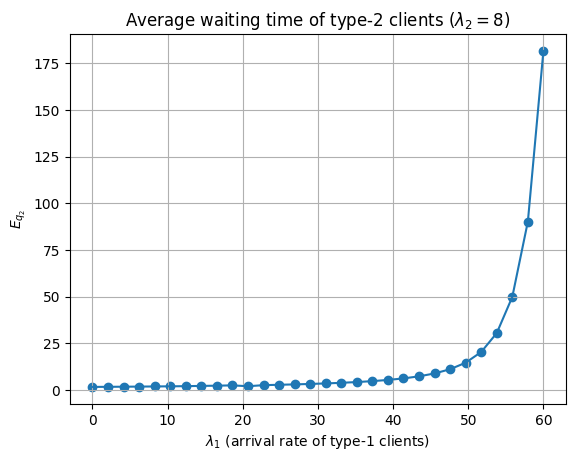

In [269]:
# Plot results
print(f'{S = },\n{mu_1 = },\n{mu_2 = },\n{lambda_2 = }')
plt.plot(lambdas_1, avg_times)
plt.scatter(lambdas_1, avg_times)
plt.title("Average waiting time of type-2 clients ($\\lambda_2 = 8$)")
plt.xlabel("$\\lambda_1$ (arrival rate of type-1 clients)")
plt.ylabel("$E_{q_2}$")
plt.grid(True)
plt.show()

## 6. Canaux de garde

Comme il est difficile d’implémenter la politique préemptive, on se contente souvent d’un système de canaux de garde. Les arrivées de classe 1 occupent un serveur tant qu’il y a un de libre et ne peuvent être mis dans la salle d’attente. En d’autres termes, si tous les serveurs sont pris, éventuellement en partie par des clients de classe 2, les clients de classe 1 qui arrivent sont perdus.

Les clients de classe 2 ne peuvent entrer dans les serveurs que s’il y a au moins $ G $ serveurs libres (avec $ G $ à déterminer mais généralement très petit devant $ S $). Cette règle s’applique à leur arrivée ou au moment où un serveur se libère.

### Partie 5

1. **Pourquoi est-ce que le processus $ (Q_1, Q_2) $ défini précédemment n’est plus un processus de Markov représentant ce système ?**


> &nbsp;
>
> In the system above, class 2 clients can only be served if there are $G$ free servers, meaning the state transitions depend on a past condition about the servers, not only on $(Q_1, Q_2)$. For example, if there are $Q_1$ class 1 clients being served, the amount of servers available to serve class 2 clients is dynamic and cannot be deduced only from $(Q_1, Q_2)$ - which does not follow Markovian process properties.
>
> &nbsp;


2. **Représenter la dynamique de ce système par un processus de Markov dont on précisera le générateur infinitésimal.**


> &nbsp;
>
> We need to include adicional information about the servers state, thus we can define new states $X_1, X_2$, $B$ where:
> - $X_1$ is the number of type 1 clients being served 
> - $X_2$ is the number of type 2 clients being served   
> - $B$ is the number of type 2 clients in the buffer  
> The possible transitions are:
> - $X_1 \rightarrow X_1+1$  
> Type 1 client arrives with rate $\lambda_1$ if there are available servers ($X_1+X_2 < S$)
> - $X_1 \rightarrow X_1-1$  
> Type 1 client leaves with rate $X_1\mu_1$ unconditionally
> - $X_2 \rightarrow X_2+1$  
> Type 2 client is served right away - with rate $\lambda_2$- if the buffer is empty ($B = 0$)
> - $X_2 \rightarrow X_2-1$  
> Type 2 client leaves  with rate $X_2\mu_2$ if the buffer is empty. Otherwise, it would only be "replaced" by another type 2 client from the buffer.
> - $B \rightarrow B+1$  
> Type 2 client arrives if there are not $G$ available servers ($S - (X_1+X_2) < G$)  
> - $B \rightarrow B-1$  
> Type 2 client is served from the buffer if there are at least $G$ available servers $(S - (X_1+X_2) \geq G) \text{ and } B > 0$ 
> 
> &nbsp;


3. **Sans faire de calculs, est-ce que la condition de stabilité est plus ou moins contraignante sur $ \rho_2 $ que dans le premier modèle ?**


> &nbsp;
> 
> The stability condition is more restrictive on $ \rho_2 $ for the guard channel model than for the preemptive model. In the preemptive priority system, class 1 customers can always preempt a server even if all the servers are already occupied serving class 2 customers. Thus class 1 customers are never delayed, and class 2 customers can be served by any server that is not busy at the time with class 1 customers. There is no long-term reservation of servers for class 1; the system allocates servers dynamically based on demand and priority. Thus, class 2 customers have access to the full server capacity when class 1 demand is low, and the only restriction on $ \rho_2 $ comes from the overall system resource average usage. 
>
> In comparison, the guard channel model has a strict constraint: class 2 customers may use servers only when at least $ G $ servers are free, meaning that some portion of the servers is effectively reserved for potential class 1 arrivals at all times. Class 2 customers cannot use those servers even if class 1 customers are not present. Then, the maximum number of servers to be used by class 2 is permanently reduced to $ S - G $, and this decreases their effective service capacity. So to be stable and not to have an overload of class 2 customers, the arrival rate $ \lambda_2 $ relative to the service rate $ \mu_2 $ must be lower than in the preemptive model. This makes the stability condition in the guard channel model more constraining on $ \rho_2 $, since class 2 customers are subject to a more limiting access policy that does not allow them to use some of the resources even if they are available.
> 
> In summary, as class 2 clients have less access to servers in the guard channel model due to the reservation policy, the system can sustain a smaller load from class 2 clients. Thus, the stability condition on $ \rho_2 $ is more restrictive than in the preemptive model.
>
> &nbsp;